## Suggested model for leaves

 دسته‌بندی و خوشه‌بندی بر روی مجموعه داده‌ای  شامل ویژگی‌های برگ ۳۶ گیاه مختلف  

دو روش :

K-means برای خوشه‌بندی

RandomForest برای دسته‌بندی

ابتدا، باید داده‌ها را پیش‌پردازش کنیم، سپس مدل‌های مورد نظر را آموزش دهیم و در نهایت، نتایج را ارزیابی کنیم.


 ## پیش‌پردازش


حذف داده‌های پرت (outliers)، تمیز کردن داده‌ها (مانند حذف رکوردهایی که دارای مقادیر نامعتبر هستند)، 
و تبدیل ویژگی‌ها به فرم مناسب برای مدل‌های یادگیری ماشین


In [143]:
import cv2
import numpy as np
import os
import pandas as pd
import glob

def detect_edges_and_features(directory):
    feature_list = []
    print("Script started")  # This should print when the script runs

    for leaf_image_path in glob.glob(os.path.join(directory, "*.JPG")):
        print(f"Processing file: {leaf_image_path}")  # Debugging line

        # Read the image
        img = cv2.imread(leaf_image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Apply Canny edge detection
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)

        # Debugging: Save or show the edges image
        cv2.imwrite('edges.jpg', edges)
        # or use cv2.imshow('edges', edges) to display

        # Detect lines using Hough Transform
        lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
        
        # Extract features
        if lines is not None:
            print(f"Lines detected: {len(lines)}")  # Debugging line
            for rho, theta in lines[0]:
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                y0 = b * rho
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                
                # Add features to the list
                feature_list.append([os.path.basename(directory), leaf_image_path, x1, y1, x2, y2])
        else:
            print("No lines detected.")  # Debugging line
    
    return feature_list

# Directory path where the images are stored
directory = "./leaves_Pic/extracted/" # Make sure this is your correct directory path

# Check if the directory exists
if not os.path.isdir(directory):
    print(f"Directory does not exist: {directory}")
else:
    jpg_files = glob.glob(os.path.join(directory, "*.jpg")) + glob.glob(os.path.join(directory, "*.JPG"))
    print(f"Found {len(jpg_files)} .jpg/.JPG files: {jpg_files}")

    if len(jpg_files) == 0:
        print("No .jpg/.JPG files found. Check your directory and file extensions.")

# Call the function to extract features
features = detect_edges_and_features(directory)

# Save the features to a CSV file
df = pd.DataFrame(features, columns=["Category", "Leaf Image", "Line Start X", "Line Start Y", "Line End X", "Line End Y"])
df.to_csv("extracted_features.csv", index=False)


Found 886 .jpg/.JPG files: ['./leaves_Pic/extracted\\iPAD2_C01_EX01.JPG', './leaves_Pic/extracted\\iPAD2_C01_EX02.JPG', './leaves_Pic/extracted\\iPAD2_C01_EX03.JPG', './leaves_Pic/extracted\\iPAD2_C01_EX04.JPG', './leaves_Pic/extracted\\iPAD2_C01_EX05.JPG', './leaves_Pic/extracted\\iPAD2_C01_EX06.JPG', './leaves_Pic/extracted\\iPAD2_C01_EX07.JPG', './leaves_Pic/extracted\\iPAD2_C01_EX08.JPG', './leaves_Pic/extracted\\iPAD2_C01_EX09.JPG', './leaves_Pic/extracted\\iPAD2_C01_EX10.JPG', './leaves_Pic/extracted\\iPAD2_C01_EX11.JPG', './leaves_Pic/extracted\\iPAD2_C01_EX12.JPG', './leaves_Pic/extracted\\iPAD2_C02_EX01.JPG', './leaves_Pic/extracted\\iPAD2_C02_EX02.JPG', './leaves_Pic/extracted\\iPAD2_C02_EX03.JPG', './leaves_Pic/extracted\\iPAD2_C02_EX04.JPG', './leaves_Pic/extracted\\iPAD2_C02_EX05.JPG', './leaves_Pic/extracted\\iPAD2_C02_EX06.JPG', './leaves_Pic/extracted\\iPAD2_C02_EX07.JPG', './leaves_Pic/extracted\\iPAD2_C02_EX08.JPG', './leaves_Pic/extracted\\iPAD2_C02_EX09.JPG', './lea

In [144]:

import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np

# Reading the CSV files
data1 = pd.read_csv('extracted_features.csv', header=None)
data2 = pd.read_csv('leaves.csv', header=None)

# Merging data1 and data2 into a single DataFrame
data = pd.concat([data1, data2], ignore_index=True)

# Removing duplicates
data.drop_duplicates(inplace=True)

# Assuming the first column is the target variable and the rest are features
target_column = data.iloc[:, 0]
features = data.iloc[:, 1:]

# Convert the target column to string type to ensure uniformity
target_column = target_column.astype(str)

# Encode the target variable
encoder = LabelEncoder()
target_encoded = encoder.fit_transform(target_column)

# Filter out non-numeric columns from features
features_numeric = features.select_dtypes(include=[np.number])

# Impute missing values in numeric features with the mean
imp_numeric = SimpleImputer(missing_values=np.nan, strategy='mean')
features_numeric_imputed = imp_numeric.fit_transform(features_numeric)

# Preprocess features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_numeric_imputed)


## K-means خوشه‌بندی با

 تعداد خوشه‌ها یعنی کا را به عنوان ورودی می‌گیرد و بر اساس فاصله بین نقاط، آنها را در خوشه‌های مختلف قرار می‌دهد

In [145]:
# خوشه‌بندی با K-means   56%  before img_extracted
# kmeans = KMeans(n_clusters=4, random_state=45) # فرض اینکه K=4
# clusters = kmeans.fit_predict(data)
# # clusters = kmeans.labels_

# clusters
# # data


# Dimensionality reduction with PCA
pca = PCA(n_components=1)
features_pca = pca.fit_transform(features_scaled)

# Clustering with KMeans
kmeans = KMeans(n_clusters=25, random_state=45)
clusters = kmeans.fit_predict(features_pca)

# Evaluating with Silhouette Score
silhouette_avg = silhouette_score(features_pca, clusters)
print(f'Silhouette Score: {silhouette_avg}')

# Displaying results
result_df = pd.DataFrame({'Cluster': clusters, 'Target': target_encoded})
print(result_df.groupby(['Cluster', 'Target']).size())



#====================================================================================== 53%
# from sklearn.cluster import DBSCAN

# # خوشه‌بندی با DBSCAN
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# clusters_dbscan = dbscan.fit_predict(X_pca)

# # ارزیابی با Silhouette Score
# silhouette_avg_dbscan = silhouette_score(X_pca, clusters_dbscan)
# print(f'Silhouette Score (DBSCAN): {silhouette_avg_dbscan}')

# # نمایش نتایج
# result_df_dbscan = pd.DataFrame({'Cluster': clusters_dbscan, 'Category': y})
# print(result_df_dbscan.groupby(['Cluster', 'Category']).size())


#====================================================================================== 54%
# from sklearn.cluster import AgglomerativeClustering

# # خوشه‌بندی با Agglomerative Clustering
# agg_clustering = AgglomerativeClustering(n_clusters=25)
# clusters_agg = agg_clustering.fit_predict(X_pca)

# # ارزیابی با Silhouette Score
# silhouette_avg_agg = silhouette_score(X_pca, clusters_agg)
# print(f'Silhouette Score (Agglomerative Clustering): {silhouette_avg_agg}')

# # نمایش نتایج
# result_df_agg = pd.DataFrame({'Cluster': clusters_agg, 'Category': y})
# print(result_df_agg.groupby(['Cluster', 'Category']).size())

#======================================================================================
# from sklearn.cluster import SpectralClustering

# # خوشه‌بندی با Spectral Clustering
# spectral = SpectralClustering(n_clusters=25, assign_labels="discretize")
# clusters_spectral = spectral.fit_predict(X_pca)

# # ارزیابی با Silhouette Score
# silhouette_avg_spectral = silhouette_score(X_pca, clusters_spectral)
# print(f'Silhouette Score (Spectral Clustering): {silhouette_avg_spectral}')

# # نمایش نتایج
# result_df_spectral = pd.DataFrame({'Cluster': clusters_spectral, 'Category': y})
# print(result_df_spectral.groupby(['Cluster', 'Category']).size())

#======================================================================================
# from sklearn.cluster import MeanShift, estimate_bandwidth

# # تخمین فاصله بین خوشه‌ها
# bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=X_pca.shape[0])

# # خوشه‌بندی با Mean Shift
# ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
# clusters_ms = ms.fit_predict(X_pca)

# # ارزیابی با Silhouette Score
# silhouette_avg_ms = silhouette_score(X_pca, clusters_ms)
# print(f'Silhouette Score (Mean Shift Clustering): {silhouette_avg_ms}')

# # نمایش نتایج
# result_df_ms = pd.DataFrame({'Cluster': clusters_ms, 'Category': y})
# print(result_df_ms.groupby(['Cluster', 'Category']).size())



Silhouette Score: 0.6179458250157762
Cluster  Target
0        3         3
         4         2
         8         1
         13        2
         14        1
                  ..
23       27        1
         29        1
24       1         3
         4         1
         14        1
Length: 198, dtype: int64


c:\Users\Almahdi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## RandomForest دسته‌بندی با

این مدل می‌تواند بر اساس ویژگی‌های ورودی، نمونه‌ها را به دسته‌های مختلف تقسیم کند.

In [146]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming 'data' is your DataFrame and it has been loaded previously

# Check if the target column exists
if 'class' in data.columns:
    print("'class' column exists.")
else:
    print("'class' column does not exist.")

# If the column exists, proceed with dropping it and splitting the data
if 'class' in data.columns:
    X = data.drop('class', axis=1)
    y = data['class']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define preprocessing pipelines for both numeric and categorical data
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, X.select_dtypes(include=[np.number]).columns),
            ('cat', categorical_transformer, X.select_dtypes(include=[object]).columns)])

    # Prepare the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', RandomForestClassifier())])

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions and evaluate
    y_pred = pipeline.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
else:
    print("Skipping data preparation steps since 'class' column does not exist.")



## ==========================================================================================



'class' column does not exist.
Skipping data preparation steps since 'class' column does not exist.


## Others Classifiers

In [147]:
#========================================================================= neural network 40%
# NOT GOOD
# from sklearn.feature_selection import mutual_info_regression, RFE
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from sklearn.metrics import accuracy_score, confusion_matrix
# import numpy as np

# # جدا کردن ویژگی‌ها و هدف
# X = data[:, 1:] # تمام ستون‌ها به جز اولین ستون به عنوان ویژگی‌ها
# y = data[:, 0].astype(int) # اولین ستون به عنوان هدف و تبدیل به int

# # تقسیم داده به آموزش و تست
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# # Calculate Mutual Information
# mi_scores = mutual_info_regression(X_train, y_train)

# # Select features based on MI scores
# threshold = 0.01
# selected_features_indices = [i for i, score in enumerate(mi_scores) if score > threshold]

# # Apply feature selection to both training and testing sets
# X_train_selected = X_train[:, selected_features_indices]
# X_test_selected = X_test[:, selected_features_indices]

# # Normalize features
# scaler = StandardScaler()
# X_train_selected = scaler.fit_transform(X_train_selected)
# X_test_selected = scaler.transform(X_test_selected)

# # Define the Neural Network model
# model = Sequential([
#     Dense(32, activation='relu', input_shape=(X_train_selected.shape[1],)),
#     Dense(16, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(X_train_selected, y_train, epochs=10, batch_size=32, validation_split=0.2)

# # Evaluate the model
# _, accuracy = model.evaluate(X_test_selected, y_test)
# print("Test Accuracy:", accuracy)

# # Predictions
# y_pred = (model.predict(X_test_selected) > 0.5).astype(np.int)

# # Confusion Matrix
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


#========================================================================= SVC  58%
# from sklearn.svm import SVC

# # آموزش مدل SVC
# svc = SVC(kernel='rbf', C=1.0, gamma='scale')
# svc.fit(X_train_rfe, y_train)

# # پیش‌بینی و ارزیابی
# y_pred_svc = svc.predict(X_test_rfe)
# print("Accuracy (SVC):", accuracy_score(y_test, y_pred_svc))
# print("Confusion Matrix (SVC):\n", confusion_matrix(y_test, y_pred_svc))

#========================================================================= GradientBoostingClassifier  60%
# from sklearn.ensemble import GradientBoostingClassifier

# # آموزش مدل GBC
# gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=0.35, max_depth=5, random_state=47)
# gbc.fit(X_train_rfe, y_train)

# # پیش‌بینی و ارزیابی
# y_pred_gbc = gbc.predict(X_test_rfe)
# print("Accuracy (GBC):", accuracy_score(y_test, y_pred_gbc))
# print("Confusion Matrix (GBC):\n", confusion_matrix(y_test, y_pred_gbc))


#========================================================================= LogisticRegression  77%
# from sklearn.linear_model import LogisticRegression

# # آموزش مدل Logistic Regression
# lr = LogisticRegression(max_iter=1000)
# lr.fit(X_train_rfe, y_train)

# # پیش‌بینی و ارزیابی
# y_pred_lr = lr.predict(X_test_rfe)
# print("Accuracy (LR):", accuracy_score(y_test, y_pred_lr))
# print("Confusion Matrix (LR):\n", confusion_matrix(y_test, y_pred_lr))

#========================================================================= KNeighborsClassifier  67%
# from sklearn.neighbors import KNeighborsClassifier

# # آموزش مدل KNN
# knn = KNeighborsClassifier(n_neighbors=1)
# knn.fit(X_train_rfe, y_train)

# # پیش‌بینی و ارزیابی
# y_pred_knn = knn.predict(X_test_rfe)
# print("Accuracy (KNN):", accuracy_score(y_test, y_pred_knn))
# print("Confusion Matrix (KNN):\n", confusion_matrix(y_test, y_pred_knn))


#========================================================================= AdaBoostClassifier  14%
# from sklearn.ensemble import AdaBoostClassifier

# # آموزش مدل AdaBoost
# ada = AdaBoostClassifier(n_estimators=100, random_state=42)
# ada.fit(X_train_rfe, y_train)

# # پیش‌بینی و ارزیابی
# y_pred_ada = ada.predict(X_test_rfe)
# print("Accuracy (AdaBoost):", accuracy_score(y_test, y_pred_ada))
# print("Confusion Matrix (AdaBoost):\n", confusion_matrix(y_test, y_pred_ada))



#========================================================================= ExtraTreesClassifier  85%
from sklearn.ensemble import ExtraTreesClassifier

# آموزش مدل Extra Trees
etc = ExtraTreesClassifier(n_estimators=100, random_state=100000)
etc.fit(X_train_rfe, y_train)

# پیش‌بینی و ارزیابی
y_pred_etc = etc.predict(X_test_rfe)
print("Accuracy (Extra Trees):", accuracy_score(y_test, y_pred_etc))
print("Confusion Matrix (Extra Trees):\n", confusion_matrix(y_test, y_pred_etc))




NameError: name 'X_train_rfe' is not defined

## Model Eval

In [ ]:
print(y_pred)
print(y_test)
print(y_train)

[13  1 26 22  7  8 29 26 35 11 11  2 23 36 22 12 25  5  8 10 24 29  4 24
 12 31  7 35 14 29 28 11 33 36 33  7 10 33 14  1 29 34 13 27 12  2 30 13
 10 22  5  1  7  5 13  1 24  3  8 26 12 29  1 13  7  8 11 33]
[13 27 26 22  7  8 29 26 35 11 11  2 23 36 22 12 25  5  8 10 24 29  4  4
 12 31  7 35 14 29 28 11 24 36 33  9 10 27 14  1 29 34 13 27 22 32 30 13
 10 22  5 13  7  5  1  1 24  3  8 26 12 29 26 13 14  8 36 33]
[28 31  2 12 35 33  1 30 36 33 33 10 23 22  8 23 11 36  9 13 27 14 11 22
 13 14 10 14 30 22 24 29 26 22 15 34 31 35  3  1 10  5 31  2 26 28 15 30
 36 34  3  5 35 32  1 25 33 26 36 24  7 25 11 26  6  7 11 14 35  9 24  9
  5  6 32 25 27  3  4 31  6 12 26 24 24 32 36 26  8 15 28 29 32  2 33  7
  3 13 26 22 34 23 27 15 11 11 26 31 34  5  4  2 15 35  6  3 23 29 13  9
  3 11 25 28  4 23 32  9 33  4 35 36 31 23 33  7 15  2 32 11 28 35 11 27
 34  2 24  9 29 11 30  5 34 10 30 10 11 28 12  2 23  9 14 28 12 33 15  5
 32  6 31 31 13  5 12 13  9 22 22 30 31  8 27  1  8 15 15 12 12  8  3 27


 ## ارتباط خوشه‌ها با دسته‌ها

این کار با محاسبه توزیع دسته‌ها درون هر خوشه انجام شود


In [ ]:
# بررسی ارتباط خوشه‌ها با دسته‌ها
cluster_distribution = {}
for i, cluster in enumerate(clusters):
    cluster_items = data[clusters == cluster]
    categories_in_cluster = set(cluster_items[:, -1])
    cluster_distribution[i] = categories_in_cluster

print("Cluster distribution:", cluster_distribution)


Cluster distribution: {0: {1.1756, 1.5452, 1.5377, 1.1365, 1.3596, 1.2659, 1.8363, 1.6895, 1.7405, 1.3598, 2.2704, 2.0412, 1.4575, 1.0734, 1.5681, 1.4111, 1.6497, 1.5332, 1.4395, 1.2406, 1.3579, 1.7187, 1.6935}, 1: {0.69659, 0.66975, 0.87177, 0.94545, 1.008, 0.5341, 0.62671, 0.86218, 1.2593, 1.2269, 1.1047, 0.66423, 1.1899, 1.321, 1.2646, 0.60629, 0.67306, 0.85839, 0.82279, 1.1185, 0.64966, 1.489, 0.62317, 1.166, 1.0693, 1.2042, 0.83183}, 2: {0.44348, 0.34068, 0.49751, 0.71713, 0.67811, 0.90513, 1.0952, 1.0136, 1.3083, 1.1602, 1.0962, 0.78201, 0.60779, 1.0185, 0.63468, 0.44798, 0.49261, 0.43227, 0.37728, 1.098, 0.7658, 0.68561, 1.0006, 1.0097, 1.5623, 0.9961, 0.3475}, 3: {0.58785, 0.53904, 0.91307, 0.74174, 0.91499, 0.87687, 1.1374, 0.76676, 0.77718, 1.0843, 0.37324, 0.54481, 0.75154, 0.4391, 0.73904, 0.7271, 0.68174}, 4: {0.34214, 0.8079, 0.85025, 0.33696, 0.25026, 0.94985, 1.0503, 0.65567, 0.43769, 0.48911, 0.28857, 0.38449, 0.27688}, 5: {0.44348, 0.34068, 0.49751, 0.71713, 0.67811, 

## Tables

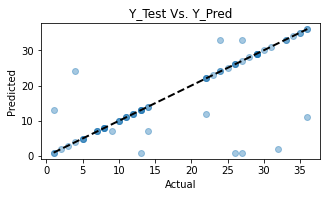

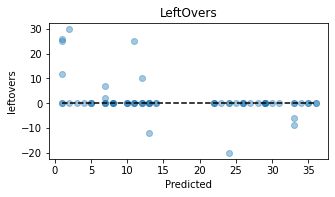

In [ ]:
import matplotlib.pyplot as plt

# test ==> actual   /    pred ==> predicted
leftovers = y_test - y_pred
#same as
plt.figure(figsize=(5,2.5))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.title("Y_Test Vs. Y_Pred")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=2)
plt.show()

#---------------------------------------------------------------------------------------
#errors
plt.figure(figsize=(5,2.5))
plt.scatter(y_pred, leftovers, alpha=0.4)
plt.title("LeftOvers")
plt.xlabel("Predicted")
plt.ylabel("leftovers")
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors="black", linestyles="--")
plt.show()
